In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np

In [2]:
def getUniqueModels(allModels):
    ##MUST PASS IN MODEL ENTITY
    ##GETS BEST MODEL FOR EACH INPUT SERIES
    sequences = {} 
    for modelEntity in allModels:
        model = modelEntity["model"]
        thisSeq = str(model.inputSeries.describe())
        if thisSeq not in sequences:
            sequences[thisSeq] = []
        sequences[thisSeq].append({
            "model":model,
            "info":modelEntity
        })
    modelsToReturn = []
    for seq in sequences:
        bestModel = None
        for modelInfo in sequences[seq]:
            if bestModel is None:
                bestModel = modelInfo
            else:
                if bestModel["info"]["STABILITY"] < modelInfo["info"]["STABILITY"]:
                    bestModel = modelInfo
        modelsToReturn.append(bestModel["model"])
    return modelsToReturn

In [20]:
import portfolio
import dataAck
import warnings
import numpy as np
warnings.filterwarnings("ignore")
tickerToTrade = "VO"
allModels = portfolio.getModels(tickerToTrade, returnEntireObject=True)
for modelEntity in allModels:
    model = modelEntity["model"]
    print(model.describe())

((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)


In [21]:
uniqueModels = getUniqueModels(allModels)
for model in uniqueModels:
    print(model.describe())

((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)


# VIEW CORRELATION AND COVARIANCE

In [22]:
def generateAllReturns(allModels, joinedData):
    aggregateReturns = None
    aggregatePredictions = None
    for mod in allModels:
        print(mod.describe())
        algoReturn, factorReturn, predictions =  mod.makePredictions(joinedData)
        algoReturn.columns = [str(mod.describe())]
        predictions.columns = [str(mod.describe())]
        if aggregateReturns is None:
            aggregateReturns = algoReturn
            aggregatePredictions = predictions
        else:
            aggregateReturns = aggregateReturns.join(algoReturn)
            aggregatePredictions = aggregatePredictions.join(predictions)
    return aggregateReturns, aggregatePredictions

In [23]:
tickersRequired = []
tickersTraded = []
for mod in uniqueModels:
    
    print(mod.describe())
    if mod.inputSeries.targetTicker not in tickersRequired:
        tickersRequired.append(mod.inputSeries.targetTicker)
    if mod.inputSeries.series.ticker not in tickersRequired:
        tickersRequired.append(mod.inputSeries.series.ticker)
    if mod.inputSeries.targetTicker not in tickersTraded:
        tickersTraded.append(mod.inputSeries.targetTicker)
    

pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
modelReturns, modelPredictions = generateAllReturns(uniqueModels, joinedData[:-252])

((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)
((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)
((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)
((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)
VO
TIP
SHY
XLV
IWF
((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
THREAD  5 PROGRESS: 0.7142857142857143
THREAD  1 PROGRESS: 0.7142857142857143
THREAD  4 PROGRESS: 0.7142857142857143
THREAD  0 PROGRESS: 0.7142857142857143
THREAD  3 PROGRESS: 0.7142857142857143
THREAD  2 PROGRESS: 0.7142857142857143
THREAD  6 PROGRESS: 0.7142857142857143
THREAD  7 PROGRESS: 0.7142857142857143
THREAD  8 PROGRESS: 0.7142857142857143
THREAD  10 PROGRESS: 0.7317073170731707
THREAD  9 PROGRESS: 0.7317073170731707
THREAD  13 PROGRESS: 0.7317073170731707
THREAD  12 PROGRESS: 0.7317073170731707
THREAD  15 PROGRESS: 0.7317073170731707
THREAD  20 PROGRESS: 0.7317073170731707
THREAD  11 PROGRESS: 0.7317073170731707
THREAD  19 PROGRESS: 0.7317073170731707
THREAD  14 PROGRESS: 0

In [24]:
modelReturns

,"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)","((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)","((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)","((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)"
2006-10-17,0.000198,0.000397,-0.000397,NaN,NaN
2006-10-18,-0.001509,-0.003019,0.003019,NaN,NaN
2006-10-19,0.003920,0.002614,-0.005227,NaN,NaN
2006-10-20,-0.004140,0.000000,0.004140,NaN,NaN
2006-10-23,-0.003172,0.001586,0.000000,NaN,NaN
2006-10-24,-0.002845,0.001423,-0.002845,NaN,NaN
2006-10-25,-0.008354,0.004177,-0.008354,NaN,NaN
2006-10-26,0.004846,-0.004846,0.009692,NaN,NaN
2006-10-27,-0.000947,0.000000,0.000000,0.000947,NaN
2006-10-30,0.000867,-0.000000,-0.000000,-0.001733,NaN


In [31]:
modelPredictions

,"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)","((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)","((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)","((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)"
2006-10-17,-0.25,-0.5,0.5,NaN,NaN
2006-10-18,-0.50,-1.0,1.0,NaN,NaN
2006-10-19,-0.75,-0.5,1.0,NaN,NaN
2006-10-20,-1.00,0.0,1.0,NaN,NaN
2006-10-23,-1.00,0.5,0.0,NaN,NaN
2006-10-24,-1.00,0.5,-1.0,NaN,NaN
2006-10-25,-1.00,0.5,-1.0,NaN,NaN
2006-10-26,-0.50,0.5,-1.0,NaN,NaN
2006-10-27,-0.50,0.0,0.0,0.5,NaN
2006-10-30,-0.50,0.0,0.0,1.0,NaN


In [26]:
modelReturnsWithFactor = modelReturns.join(dataAck.getDailyFactorReturn(tickerToTrade, joinedData))

In [27]:
def visualizeModels(modelReturns):
    from string import ascii_letters
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from IPython.display import display

    sns.set(style="white")


    # Compute the correlation matrix
    corr = modelReturns.corr()
    display(corr)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    from matplotlib.colors import ListedColormap

    # construct cmap
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    cmap = ListedColormap(sns.color_palette(flatui).as_hex())
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
    sns.set(style="white")
    
    # Compute the covariance matrix
    cov = modelReturns.cov()
    display(cov)
    # Generate a mask for the upper triangle
    mask = np.zeros_like(cov, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    cmap = ListedColormap(sns.color_palette(flatui).as_hex())

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(cov, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

,"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)","((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)","((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)","((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)",Factor Return
"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)",1.000000,0.051233,0.310880,0.087778,0.179273,0.316566
"((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)",0.051233,1.000000,0.147758,0.099155,0.074055,0.393343
"((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)",0.310880,0.147758,1.000000,0.019536,-0.097238,0.219498
"((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)",0.087778,0.099155,0.019536,1.000000,0.232319,0.047059
"((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)",0.179273,0.074055,-0.097238,0.232319,1.000000,0.273095
Factor Return,0.316566,0.393343,0.219498,0.047059,0.273095,1.000000


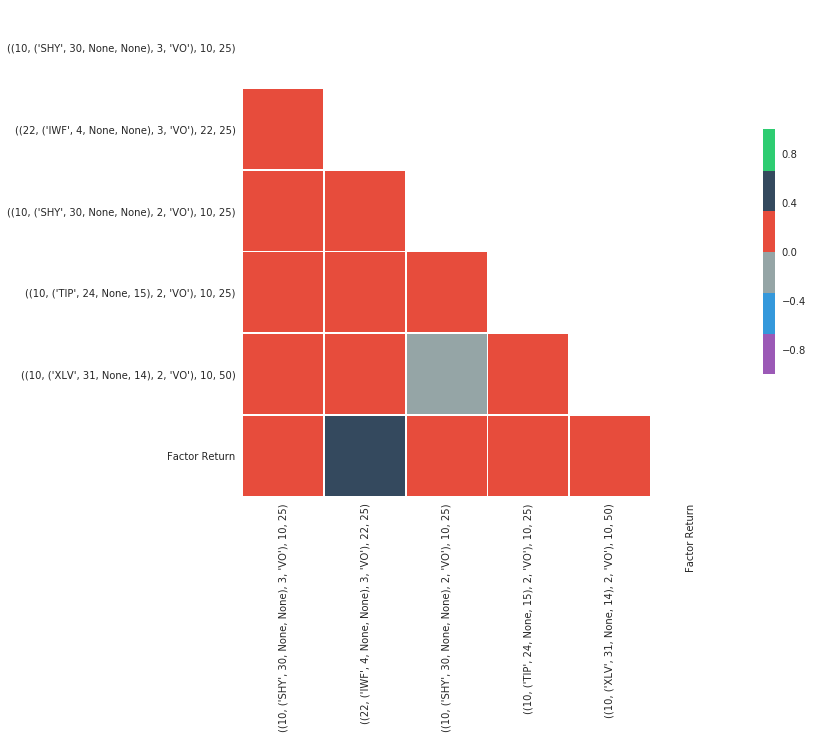

,"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)","((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)","((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)","((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)","((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)",Factor Return
"((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)",0.000078,0.000004,0.000031,0.000010,0.000019,0.000041
"((22, ('IWF', 4, None, None), 3, 'VO'), 22, 25)",0.000004,0.000078,0.000015,0.000011,0.000008,0.000051
"((10, ('SHY', 30, None, None), 2, 'VO'), 10, 25)",0.000031,0.000015,0.000128,0.000003,-0.000014,0.000037
"((10, ('TIP', 24, None, 15), 2, 'VO'), 10, 25)",0.000010,0.000011,0.000003,0.000152,0.000035,0.000009
"((10, ('XLV', 31, None, 14), 2, 'VO'), 10, 50)",0.000019,0.000008,-0.000014,0.000035,0.000151,0.000050
Factor Return,0.000041,0.000051,0.000037,0.000009,0.000050,0.000219


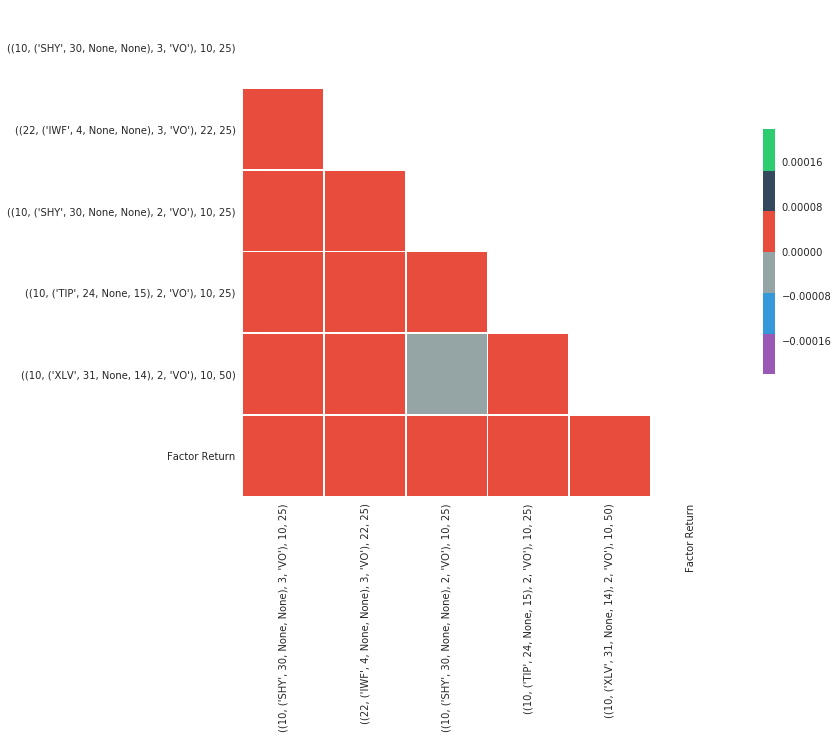

In [28]:
%matplotlib inline
visualizeModels(modelReturnsWithFactor)

# STORE MODELS AS PORTFOLIO

In [53]:
def storePastPredictions(allModels, modelPredictions):
    ##SHIFT -1 IS EQUIVALENT TO LOOKING AT LAST AVAILABLE
    lastDayUsedPredictions = modelPredictions.shift(-1).dropna()
    for i in range(len(lastDayUsedPredictions.columns)):
        thisModel = allModels[i]
        print(thisModel.describe())
        thisDF = lastDayUsedPredictions[[lastDayUsedPredictions.columns[i]]]
        for i in range(len(thisDF.values)):
#             print(thisDF.index[i], thisDF.values[i][0])
            portfolio.storeModelPrediction(thisModel, thisDF.values[i][0], thisDF.index[i])
            print(i)

            

In [54]:
storePastPredictions(uniqueModels, modelPredictions)

((10, ('SHY', 30, None, None), 3, 'VO'), 10, 25)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


Exception ignored in: 'grpc._cython.cygrpc.plugin_get_metadata'
Traceback (most recent call last):
  File "/home/prohb125/anaconda3/lib/python3.6/site-packages/grpc/_plugin_wrapping.py", line 99, in __call__
    def __call__(self, context, cygrpc_callback):
KeyboardInterrupt


UPLOAD ERROR: (<class 'KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x7fb553878448>)


KeyboardInterrupt: 

In [32]:
def storePortfolio(models, description, benchmark):
    allHashes = []
    for model in models:
        organismHash = hashlib.sha224(str(model.describe()).encode('utf-8')).hexdigest()
        allHashes.append(organismHash)
    
    allHashes.sort()
    portfolioHash = hashlib.sha224(str(allHashes).encode('utf-8')).hexdigest()
    print("PORTFOLIO HASH:", portfolioHash)
    for hashing in allHashes:
        print(hashing)
        
    
        ##UPLOAD ORGANISM OBJECT
        while True:
            try:
                toUpload = {
                    "portfolio":portfolioHash,
                    "model":hashing
                }
                datastoreClient = datastore.Client('money-maker-1236')
                #HASH DIGEST
                key = datastoreClient.key(params.portfolioDB, hashlib.sha224(str(hashing + portfolioHash).encode('utf-8')).hexdigest()) #NEED TO HASH TO ENSURE UNDER COUNT
                organismToStore = datastore.Entity(key=key)
                organismToStore.update(toUpload)
                datastoreClient.put(organismToStore)
                break
            except:
                print("UPLOAD ERROR:", str(sys.exc_info()))
                time.sleep(10)
    
    ##STORE PORTFOLIO OBJECT
    while True:
        try:
            toUpload = {
                "description":description,
                "benchmark":benchmark
            }
            datastoreClient = datastore.Client('money-maker-1236')
            #HASH DIGEST
            key = datastoreClient.key(params.portfolioLookup, portfolioHash) #NEED TO HASH TO ENSURE UNDER COUNT
            organismToStore = datastore.Entity(key=key)
            organismToStore.update(toUpload)
            datastoreClient.put(organismToStore)
            break
        except:
            print("UPLOAD ERROR:", str(sys.exc_info()))
            time.sleep(10)

In [30]:
storePortfolio(uniqueModels, description=tickerToTrade + " 8-13-17", benchmark=tickerToTrade)

PORTFOLIO HASH: 8d2f03a0255fb23c126417c182491b9c7d5d8181e30e4f51b67022ae
1143a01d3318dc77e322827e93e4e8bcc57cfd8b25527d78d966ae56
fdaede0c6f3ebe4c59923d9609dd55c7ded15b67544c48cb316af744


In [31]:
def getPortfolios():
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.portfolioLookup)
            retrievedPortfolios = [{
                "key":item.key.name,
                "description":item["description"],
                "benchmark":item["benchmark"]
            } for item in list(query.fetch())]

            return retrievedPortfolios
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [32]:
portfolios = getPortfolios()
print(portfolios)

[{'key': '514d5ee998b05536888778bb1d1d48d638992056a6ed8bdb2023cee2', 'description': 'EWZ 08-11-19'}, {'key': '8d2f03a0255fb23c126417c182491b9c7d5d8181e30e4f51b67022ae', 'description': 'XLY 08-11-17'}]


In [33]:
def getPortfolioModels(portfolioKey):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            query = datastore_client.query(kind=params.portfolioDB)
            query.add_filter('portfolio', '=', portfolioKey)
            
            retrievedModels = [item["model"] for item in list(query.fetch())]

            return retrievedModels
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [34]:
for item in portfolios:
    print(item)
    print(getPortfolioModels(item["key"]))

{'key': '514d5ee998b05536888778bb1d1d48d638992056a6ed8bdb2023cee2', 'description': 'EWZ 08-11-19'}
['bafabbb2ddbb6e294ed821e1e1e41116981d49addb415b95798bb67e', 'e1111d514a667ab22d8f48a2734a7dab0be1350f8ce70ca3b8a172ac', 'beef2ac53b15ac017d4a6c61d83d1a8126ca82d4025fbfbd582fb8df', 'bad9f9f22f779a70cccb3c9197c9f0b5229ce68f4c648aa04e04f97f', '30e79488fb925fedbb3f63f6abb86757c4763d92bc4e893a87556d59', '419d1aadd49f8b53c9f732b304c4d41a0576d4c721a3da0c0e0c7730', '584efc9e68aed8795e0138754b77cc3c760d3454153bddf090caf8f9', 'c26a1518a8eb9d58caca155d4bb0dfbb0a52574d37e69cd3eb48282e', '7ff98f4707692aaf28e9b72000b57a7934e07a7d715957e4e389bff2']
{'key': '8d2f03a0255fb23c126417c182491b9c7d5d8181e30e4f51b67022ae', 'description': 'XLY 08-11-17'}
['fdaede0c6f3ebe4c59923d9609dd55c7ded15b67544c48cb316af744', '1143a01d3318dc77e322827e93e4e8bcc57cfd8b25527d78d966ae56']


In [35]:
def getModelsByKey(modelHashes):
    while True:
        try:
            datastore_client = datastore.Client('money-maker-1236')
            ##form keys
            keys = []
            for hashing in modelHashes:
                key = datastore_client.key(params.datastoreName, hashing)
                keys.append(key)
                
            retrievedModels = datastore_client.get_multi(keys)
            toReturn = []
            for source in retrievedModels:
                toReturn.append(pickle.loads(source["model"]))
            return toReturn
            
        except:
            time.sleep(10)
            print("DATA SOURCE RETRIEVAL ERROR:", str(sys.exc_info()))

In [36]:
getModelsByKey(getPortfolioModels(item["key"]))

[<dataAck.algoBlob at 0x7ffaa8f1c4a8>, <dataAck.algoBlob at 0x7ffaa8f1c8d0>]